In [0]:
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import pandas as pd
pd.options.display.max_rows = 20
import matplotlib.pyplot as plt
import numpy as np

bg = pd.read_excel('/content/drive/My Drive/EEC 193/EEC 193B/Burn_Glucose_022020.xlsx', skiprows = 0)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
bg

,PER_CODE,Collection Date,Time Vitals,Systolic,Diastolic,MAP,HR,RR,Temp,CVP,GCS,Vent,Time_CBC,WBC,Hgb,Hct,Platelet,Time Labs,Na,K_pos,BUN,Creatnine,Glucose,Tbili,Chloride,V_CO2,PaO2,FIO2,PaCO2,HCO3,PH,Sepsis
0,21,2011-01-02,614.0,113.0,67.0,78.0,102.0,15.0,37.0,7.0,15.0,No,5.0,6.9,8.1,24.5,578.0,5.0,136.0,3.6,7.0,0.53,110.0,0.3,101.0,29.0,NaN,NaN,NaN,NaN,NaN,0
1,21,2011-01-03,600.0,137.0,67.0,85.0,105.0,16.0,37.3,7.0,15.0,No,59.0,7.8,7.9,25.1,615.0,59.0,137.0,3.7,8.0,0.55,130.0,0.3,104.0,27.0,NaN,NaN,NaN,NaN,NaN,0
2,21,2011-01-04,1000.0,124.0,56.0,73.0,104.0,18.0,37.5,7.0,15.0,No,208.0,8.9,8.7,26.6,607.0,208.0,135.0,3.4,8.0,0.53,172.0,0.3,103.0,24.0,NaN,NaN,NaN,NaN,NaN,0
3,21,2011-01-05,930.0,143.0,69.0,85.0,104.0,18.0,37.5,7.0,15.0,No,103.0,9.3,8.4,25.7,414.0,103.0,134.0,4.8,10.0,0.49,150.0,0.3,103.0,25.0,NaN,0.21,NaN,NaN,NaN,0
4,21,2011-01-06,1130.0,130.0,59.0,83.0,104.0,23.0,38.0,7.0,15.0,No,130.0,8.4,8.9,27.7,701.0,130.0,136.0,3.5,11.0,0.51,109.0,0.3,103.0,27.0,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6536,PCR-004-00018,2013-05-27,600.0,140.0,70.0,102.0,116.0,26.0,38.5,NaN,NaN,No,211.0,17.6,9.2,26.8,454.0,211.0,138.0,4.5,12.0,0.88,139.0,NaN,103.0,25.0,NaN,NaN,NaN,NaN,NaN,0
6537,PCR-004-00018,2013-05-28,600.0,158.0,53.0,82.0,110.0,22.0,37.8,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6538,PCR-004-00018,2013-05-29,600.0,133.0,51.0,72.0,120.0,22.0,38.5,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6539,PCR-004-00018,2013-05-30,600.0,118.0,49.0,73.0,118.0,22.0,38.8,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Data Preprocessing ##


In [0]:
def Drop_nan_row(df):
  
  drop_idx = []
  for i in range(len(df)):
    nan_count = 0
    for x in df.loc[i]:
      if str(x) == 'nan':
        nan_count += 1
    if nan_count >= 15:
      drop_idx.append(i)
    
  modified_df = df.drop(df.index[drop_idx], errors = 'ignore')
  modified_df = modified_df.reset_index(drop = True)

  return modified_df

In [0]:
def Drop_unrelated_cols(df):
  df = df.drop(columns = ['PER_CODE', 'Collection Date', 'Time Vitals', 'Time Labs', 'Time_CBC', 'Vent'], errors = 'ignore')
  return df

In [0]:
def Drop_nan_col(df):
  
  num_rows = len(df)
  for x in df:
    num_nan = 0
    for i in df[x]:
      if str(i) == 'nan':
        num_nan += 1
    
    if (num_nan/num_rows) >= 0.2:
      df = df.drop(columns = x, errors = 'ignore')
  
  return df

In [0]:
def Complete_dataset(df):

  # Change "Yes" and "No" under "Vent" to 1 and 0
  df = df.replace('No', 0)
  df = df.replace('Yes', 1)

  # drop nan or replace them with other value
  df = df.dropna()
  df = df.reset_index(drop = True)

  return df

In [0]:
def data_preprocess(df):

  # drop rows that have too many nan
  df = Drop_nan_row(df)
  # drop times and patient ids
  df = Drop_unrelated_cols(df)
  # drop cols that have too many nan
  df = Drop_nan_col(df)
  # Replace all the other nans
  df = Complete_dataset(df)

  return df

In [0]:
bg = data_preprocess(bg)

## Finding Score ##

In [0]:
pip install -U imbalanced-learn

     |████████████████████████████████| 163kB 2.7MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn import svm
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
import imblearn

Using TensorFlow backend.


In [0]:
# def Scores_calculation(train_x, train_y, test_x, test_y):
#   precision_scores = [[],[]]
#   recall_scores = [[],[]]
#   f1_score_scores = [[],[]]

#   model = RandomForestClassifier()
#   for i in range(0,10):
#     model.fit(train_x, train_y)
#     predictions = model.predict(test_x)
#     report = classification_report(test_y, predictions, output_dict = True)

#     precision_scores[0].append(report['0']['precision'])
#     recall_scores[0].append(report['0']['recall'])
#     f1_score_scores[0].append(report['0']['f1-score'])
    
#     precision_scores[1].append(report['1']['precision'])
#     recall_scores[1].append(report['1']['recall'])
#     f1_score_scores[1].append(report['1']['f1-score'])

#   precision_scores_avg_0 = sum(precision_scores[0]) / 10
#   recall_scores_avg_0 = sum(recall_scores[0]) / 10
#   f1_score_scores_avg_0 = sum(f1_score_scores[0]) / 10

#   precision_scores_avg_1 = sum(precision_scores[1]) / 10
#   recall_scores_avg_1 = sum(recall_scores[1]) / 10
#   f1_score_scores_avg_1 = sum(f1_score_scores[1]) / 10

#   # print('0 precision average', precision_scores_avg_0)
#   # print('1 precision average', precision_scores_avg_1)
#   # print('0 recall average', recall_scores_avg_0)
#   # print('1 recall average', recall_scores_avg_1)
#   # print('0 f1_socre average', f1_score_scores_avg_0)
#   # print('1 f1_socre average', f1_score_scores_avg_1)
#   # print('average f1_scores', (f1_score_scores_avg_0 + f1_score_scores_avg_1)/2)

#   return (f1_score_scores_avg_0 + f1_score_scores_avg_1)/2

## Getting Best Features ##

### Progressive Selection ###

In [0]:
# model = RandomForestClassifier()
# x = bg[['Hct', 'Platelet', 'WBC', 'Glucose']].values
# y = bg['Sepsis'].values
# train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

# scaler = RobustScaler()
# train_x = scaler.fit_transform(train_x)
# test_x = scaler.transform(test_x)

# n_minority = len(train_y[train_y == 1])
# n_majority = int(n_minority * 2.5)
# sampling_numbers = {0: n_majority, 1: n_minority}

# rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=sampling_numbers)
# train_x_rus, train_y_rus = rus.fit_resample(train_x, train_y)
# train_y_rus = pd.Series(train_y_rus)
  
# score = Scores_calculation(train_x_rus, train_y_rus, test_x, test_y)
# print(score)

In [0]:
# model = RandomForestClassifier()
# temp = list(bg.columns)
# temp.remove('Hct')
# temp.remove('Platelet')
# temp.remove('WBC')
# temp.remove('Sepsis')
# temp.remove('Temp')
# temp.remove('RR')
# temp.remove('HR')
# col_use = ['Hct', 'Platelet', 'WBC', 'Temp', 'RR', 'HR']

# for f in temp:
#   g = [f]
#   g = col_use + g

#   x = bg[g].values
#   y = bg['Sepsis'].values
#   train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

#   scaler = RobustScaler()
#   train_x = scaler.fit_transform(train_x)
#   test_x = scaler.transform(test_x)

#   n_minority = len(train_y[train_y == 1])
#   n_majority = int(n_minority * 2.5)
#   sampling_numbers = {0: n_majority, 1: n_minority}

#   rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=sampling_numbers)
#   train_x_rus, train_y_rus = rus.fit_resample(train_x, train_y)
#   train_y_rus = pd.Series(train_y_rus)
  
#   score = Scores_calculation(train_x_rus, train_y_rus, test_x, test_y)
#   print(g,':',score)
  

Best feature combination: ['Hct', 'Platelet', 'WBC', 'Temp', 'RR', 'HR']

### Regressive Selection ###

In [0]:
# from sklearn.feature_selection import RFE

# col = list(bg.columns)
# col.remove('Sepsis')
# x = bg[col].values
# y = bg['Sepsis'].values
# train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

# scaler = RobustScaler()
# train_x = scaler.fit_transform(train_x)
# test_x = scaler.transform(test_x)

# n_minority = len(train_y[train_y == 1])
# n_majority = int(n_minority * 2.5)
# sampling_numbers = {0: n_majority, 1: n_minority}

# rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=sampling_numbers)
# train_x_rus, train_y_rus = rus.fit_resample(train_x, train_y)
# train_y_rus = pd.Series(train_y_rus)

# estimator = RandomForestClassifier()
# selector = RFE(estimator, 3, step=1)
# selector = selector.fit(train_x_rus, train_y_rus)

# new_train_x = train_x[:, selector.support_]
# new_test_x = test_x[:, selector.support_]

# model = RandomForestClassifier()

# f1_score_scores = [[],[]]

# model = RandomForestClassifier()
# for i in range(0,10):
#   model.fit(new_train_x, train_y)
#   predictions = model.predict(new_test_x)
#   report = classification_report(test_y, predictions, output_dict = True)

#   f1_score_scores[0].append(report['0']['f1-score'])
#   f1_score_scores[1].append(report['1']['f1-score'])
#   f1_score_scores_avg_0 = sum(f1_score_scores[0]) / 10
#   f1_score_scores_avg_1 = sum(f1_score_scores[1]) / 10

# print((f1_score_scores_avg_0 + f1_score_scores_avg_1)/2)

3 features: f1_score = 0.5483979297526201 \\
4 features: f1_score = 0.5807557454179925 \\
5 features: f1_score = 0.5788802053854059 \\
6 features: f1_score = 0.5769307206585933 \\
7 features: f1_score = 0.5722500953954065

Random Under Sampling

## Best features + SVM + RFE + RobustScaler##




In [0]:
x = bg[['Hct', 'Platelet', 'WBC', 'Temp', 'RR', 'HR']].values
y = bg['Sepsis'].values

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

scaler = RobustScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x) # change this to change test_x

n_minority = len(train_y[train_y == 1])
n_majority = int(n_minority * 2.5)
sampling_numbers = {0: n_majority, 1: n_minority}

rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=sampling_numbers)
train_x_rus, train_y_rus = rus.fit_resample(train_x, train_y)
train_y_rus = pd.Series(train_y_rus)

f1_score_scores = [[],[]]
sensitivity = []
specificity = []

# RFE: Feature ranking with recursive feature elimination.
# SVM is a classifier -> predicting discrete categorical labels
# SVR, which stands for Support Vector Regressor, is a regressor
# SVR for continuous data, SVC for discrete data
# SVM for discrete
model = svm.SVC(kernel="linear", probability=True)
#model = RFE(estimator, 5, step=1)

for i in range(0,10):
  model.fit(train_x_rus, train_y_rus)
  predictions = model.predict(test_x) # problem?  
  report = classification_report(test_y, predictions, output_dict = True)
  ss = imblearn.metrics.sensitivity_specificity_support(test_y, predictions, average='macro')
  
  sensitivity.append(ss[0])
  specificity.append(ss[1])

  # F1 score: weighted average of the precision and recall
  f1_score_scores[0].append(report['0']['f1-score'])
  f1_score_scores[1].append(report['1']['f1-score'])

f1_score_scores_avg_0 = sum(f1_score_scores[0]) / 10
f1_score_scores_avg_1 = sum(f1_score_scores[1]) / 10
sensitivity_avg = sum(sensitivity) / 10
specificity_avg = sum(specificity) / 10

print("f1 score = ", (f1_score_scores_avg_0 + f1_score_scores_avg_1)/2)
print("sensitivity = ", sensitivity_avg)
print("specificity = ", specificity_avg)

f1 score =  0.45563674321503134
sensitivity =  0.5
specificity =  0.5


roc_auc_score =  0.5706556161983694


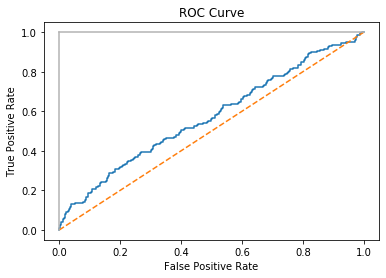

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score

y_score = model.predict_proba(test_x)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(test_y, y_score)
print('roc_auc_score = ', roc_auc_score(test_y, y_score))

plt.title('ROC Curve')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Random Over Sampling

In [0]:
x = bg[['Hct', 'Platelet', 'WBC', 'Temp', 'RR', 'HR']].values
y = bg['Sepsis'].values

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

scaler = RobustScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

n_minority = len(train_y[train_y == 1])
n_majority = int(n_minority * 40)
sampling_numbers = {0: n_majority, 1: n_minority}

ros = imblearn.over_sampling.RandomOverSampler(sampling_strategy=sampling_numbers)
train_x_ros, train_y_ros = ros.fit_resample(train_x, train_y)
train_y_ros = pd.Series(train_y_ros)

f1_score_scores = [[],[]]
sensitivity = []
specificity = []

# RFE: Feature ranking with recursive feature elimination.
# SVM is a classifier -> predicting discrete categorical labels
# SVR, which stands for Support Vector Regressor, is a regressor
# SVR for continuous data, SVC for discrete data
# SVM for discrete
estimator = svm.SVC(kernel="linear", probability=True)
model = RFE(estimator, 5, step=1)

for i in range(0,10):
  model.fit(train_x_ros, train_y_ros)
  predictions = model.predict(test_x)
  report = classification_report(test_y, predictions, output_dict = True)
  ss = imblearn.metrics.sensitivity_specificity_support(test_y, predictions, average='macro')
  
  sensitivity.append(ss[0])
  specificity.append(ss[1])

  # F1 score: weighted average of the precision and recall
  f1_score_scores[0].append(report['0']['f1-score'])
  f1_score_scores[1].append(report['1']['f1-score'])

f1_score_scores_avg_0 = sum(f1_score_scores[0]) / 10
f1_score_scores_avg_1 = sum(f1_score_scores[1]) / 10
sensitivity_avg = sum(sensitivity) / 10
specificity_avg = sum(specificity) / 10

print("f1 score = ", (f1_score_scores_avg_0 + f1_score_scores_avg_1)/2)
print("sensitivity = ", sensitivity_avg)
print("specificity = ", specificity_avg)

f1 score =  0.45563674321503134
sensitivity =  0.5
specificity =  0.5


roc_auc_score =  0.42782157536554144


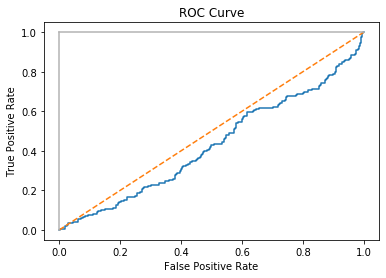

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score

y_score = model.predict_proba(test_x)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(test_y, y_score)
print('roc_auc_score = ', roc_auc_score(test_y, y_score))

plt.title('ROC Curve')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

SMOTE

In [0]:
x = bg[['Hct', 'Platelet', 'WBC', 'Temp', 'RR', 'HR']].values
y = bg['Sepsis'].values

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

scaler = RobustScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

n_minority = len(train_y[train_y == 1])
n_majority = int(n_minority * 80)
sampling_numbers = {0: n_majority, 1: n_minority}

smote = imblearn.over_sampling.SMOTE(sampling_strategy=sampling_numbers)
train_x_smote, train_y_smote = smote.fit_resample(train_x, train_y)
train_y_smote = pd.Series(train_y_smote)

f1_score_scores = [[],[]]
sensitivity = []
specificity = []

# RFE: Feature ranking with recursive feature elimination.
# SVM is a classifier -> predicting discrete categorical labels
# SVR, which stands for Support Vector Regressor, is a regressor
# SVR for continuous data, SVC for discrete data
# SVM for discrete
estimator = svm.SVC(kernel="linear", probability=True)
model = RFE(estimator, 5, step=1)

for i in range(0,10):
  model.fit(train_x_smote, train_y_smote)
  predictions = model.predict(test_x)
  report = classification_report(test_y, predictions, output_dict = True)
  ss = imblearn.metrics.sensitivity_specificity_support(test_y, predictions, average='macro')
  
  sensitivity.append(ss[0])
  specificity.append(ss[1])

  # F1 score: weighted average of the precision and recall
  f1_score_scores[0].append(report['0']['f1-score'])
  f1_score_scores[1].append(report['1']['f1-score'])

f1_score_scores_avg_0 = sum(f1_score_scores[0]) / 10
f1_score_scores_avg_1 = sum(f1_score_scores[1]) / 10
sensitivity_avg = sum(sensitivity) / 10
specificity_avg = sum(specificity) / 10

print("f1 score = ", (f1_score_scores_avg_0 + f1_score_scores_avg_1)/2)
print("sensitivity = ", sensitivity_avg)
print("specificity = ", specificity_avg)


f1 score =  0.45563674321503134
sensitivity =  0.5
specificity =  0.5


roc_auc_score =  0.5402735664712621


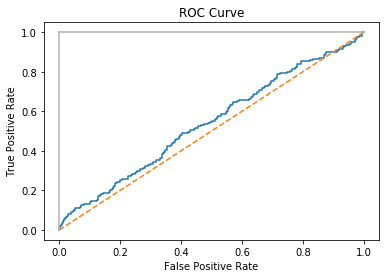

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score

y_score = model.predict_proba(test_x)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(test_y, y_score)
print('roc_auc_score = ', roc_auc_score(test_y, y_score))

plt.title('ROC Curve')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

###RUS###

**Max f1 score ~0.62 ; Max roc_auc_score ~0.69**

---
StandardScaler()  
Linear
*   0.1 test_size: f1 score =  
*   0.2 test_size: f1 score =  0.45563674321503134
*   0.3 test_size: f1 score =  
*   0.4 test_size: f1 score =  
*   0.5 test_size: f1 score =  0.4602649006622516
*   0.6 test_size: f1 score =  
*   0.7 test_size: f1 score =  
*   0.8 test_size: f1 score =  
*   0.9 test_size: f1 score =  0.46237544382086815 ; roc_auc_score =  0.6221264189051878

sigmoid (changes each time unlike linear)
*   0.1 test_size: f1 score =  ;
*   0.2 test_size: f1 score =  ;
*   0.3 test_size: f1 score =  ;
*   0.4 test_size: f1 score =  ;
*   0.5 test_size: f1 score =  f1 score =  0.5191814975438378 ; roc_auc_score =  0.5458744332658872
*   0.6 test_size: f1 score =  ;
*   0.7 test_size: f1 score =  ;
*   0.8 test_size: f1 score =  ;
*  0.9 test_size: f1 score =  f1 score =  0.5325737246934639 ; roc_auc_score =  0.5342142301783573

---
MinMaxScaler()                                                                                    
Linear
*   0.1 test_size: f1 score =  0.46130030959752333
*   0.2 test_size: f1 score =  0.45563674321503134
*   0.3 test_size: f1 score =  0.4603448275862069
*   0.4 test_size: f1 score =  0.46028460543337635
*   0.5 test_size: f1 score =  0.4602649006622516 
*   0.6 test_size: f1 score =  0.4607961399276236
*   0.7 test_size: f1 score =  0.4616632261869655
*   0.8 test_size: f1 score =  0.4621632074255511
*   0.9 test_size: f1 score =  0.46237544382086815 ; roc_auc_score =  0.5693158300937032

sigmoid (changes each time unlike linear)
*   0.1 test_size: f1 score =  ;
*   0.2 test_size: f1 score =  ;
*   0.3 test_size: f1 score =  ;
*   0.4 test_size: f1 score =  ;
*   0.5 test_size: f1 score =  f1 score =  0.4946494994056566 ; roc_auc_score =  0.5025380086555755
*   0.6 test_size: f1 score =  ;
*   0.7 test_size: f1 score =  ;
*   0.8 test_size: f1 score =  ;
*  0.9 test_size: f1 score =   f1 score =  0.46237544382086815; roc_auc_score =  0.5641278976167559

---
MaxAbsScaler()

Linear
*   0.1 test_size: f1 score =  
*   0.2 test_size: f1 score =  0.45563674321503134
*   0.3 test_size: f1 score =  
*   0.4 test_size: f1 score =  
*   0.5 test_size: f1 score =  
*   0.6 test_size: f1 score =  
*   0.7 test_size: f1 score =  
*   0.8 test_size: f1 score =  
*   0.9 test_size: f1 score =  0.46237544382086815 ; roc_auc_score =  0.5716119426507243

sigmoid (changes each time unlike linear)
*   0.1 test_size: f1 score =  ;
*   0.2 test_size: f1 score =  ;
*   0.3 test_size: f1 score =  ;
*   0.4 test_size: f1 score =  ;
*   0.5 test_size: f1 score =  f1 score =  0.4602649006622516 ; roc_auc_score =  0.508761545451139
*   0.6 test_size: f1 score =  ;
*   0.7 test_size: f1 score =  ;
*   0.8 test_size: f1 score =  ;
*  0.9 test_size: f1 score =   ;

---
RobustScaler()

Linear
*   0.1 test_size: f1 score =  
*   0.2 test_size: f1 score =  0.45563674321503134
*   0.3 test_size: f1 score =  
*   0.4 test_size: f1 score =  
*   0.5 test_size: f1 score =  
*   0.6 test_size: f1 score =  0.4607961399276236 ; roc_auc_score =  0.6092428513894482
*   0.7 test_size: f1 score =  
*   0.8 test_size: f1 score =  
*   0.9 test_size: f1 score =  0.46237544382086815 ; roc_auc_score =  **0.6456016248483868**  (f1 score same every rerun but roc_auc_score changes)
*   9 test_size: f1 score =  

Poly
*   0.1 test_size: f1 score = 0.47633269144286977 ; roc_auc_score =  0.5585682326621924
*   0.2 test_size: f1 score =  0.5300647169656755 ; roc_auc_score =  0.6301832760595647
*   0.3 test_size: f1 score =  0.5485203799423982 ; roc_auc_score =  0.622480052108777
*   0.4 test_size: f1 score =  0.5310767275741736 ; roc_auc_score =  0.39136652183545634
*   0.5 test_size: f1 score =  0.5473666028911565 ; roc_auc_score =  0.6383364011915468
*   0.6 test_size: f1 score =  0.5510387067000565; roc_auc_score =  0.627087460034356
*   0.7 test_size: **f1 score =  0.5597353368321161 ; roc_auc_score =  0.6393125199616735**
*   0.8 test_size: f1 score =  0.5521906701813244 ; roc_auc_score =  0.6177497570560659
*   0.9 test_size: f1 score =  0.5445732222249821 ; roc_auc_score = roc_auc_score =  roc_auc_score =  0.383419908438607
*   9 test_size: f1 score =  0.47058823529411764 ; roc_auc_score =  0.625 (weird graph)

rbf
*   0.1 test_size: f1 score =  0.5545147995503934 ; roc_auc_score =  0.6047129008202834
*  **0.2 test_size: f1 score =  0.5929992948634569 ; roc_auc_score =  0.6524560339599758**
*   0.3 test_size: f1 score =  0.5810169665139495; roc_auc_score =  **0.6848086630841882**
*   0.4 test_size: f1 score =  0.5602990168727221; roc_auc_score =  0.6392164832931431
*   0.5 test_size: f1 score =  0.5763794001309245; roc_auc_score =  0.6436495334982014
*   0.6 test_size: f1 score =  0.5156116669816327; roc_auc_score =  0.662561335448396
*   0.7 test_size: f1 score =  0.5696377980920485 ; roc_auc_score =  0.653539051175589
*   0.8 test_size: f1 score =  0.5856427106933392 ; roc_auc_score =  0.653539051175589
*   0.9 test_size: f1 score =  0.5560158903558627 ; roc_auc_score = roc_auc_score =  0.6602026762341794 
*   9 test_size: f1 score =  0.47058823529411764
*   1000 test_size: f1 score =  0.5570351246687955 ; roc_auc_score =  0.6724271185461269

n_minority * 2
*   0.3 test_size: f1 score =  0.6271494154290176 ; roc_auc_score =  0.6765429083211203

n_minority * 1.5
*   0.2 test_size: f1 score =  0.6313219934915585 ; roc_auc_score =  0.6800384071154234
*   0.3 test_size: **f1 score =  0.6287053155865038; roc_auc_score =  0.6934147532975083**
*   0.3 test_size: f1 score =  0.6186412865113227 ; roc_auc_score =  0.7007821967610444

sigmoid (changes each time unlike linear)
*   0.1 test_size: f1 score =  0.5013969482054589
*   0.2 test_size: f1 score =  0.5142429586874032
*   0.3 test_size: f1 score =  0.523319624726899
*   0.4 test_size: f1 score =  0.5270204378711177
*   **0.5 test_size: f1 score =  0.5359314286678617**
*   0.6 test_size: f1 score =  0.538059820921319
*   0.7 test_size: f1 score =  0.5142999814911929
*   0.8 test_size: f1 score =  0.4973805976886962
*  0.9 test_size: f1 score =   0.5288918158405201
*  9 test_size:   f1 score =  0.4375
*  999 test_size:   f1 score = 0.53994708994709 ; roc_auc_score =  0.5450541662448112


---
PowerTransformer()
Linear
*   0.1 test_size: f1 score =  
*   0.2 test_size: f1 score =  0.45563674321503134
*   0.3 test_size: f1 score =  
*   0.4 test_size: f1 score =  
*   0.5 test_size: f1 score =  
*   0.6 test_size: f1 score =  
*   0.7 test_size: f1 score =  
*   0.8 test_size: f1 score =  
*   0.9 test_size: f1 score =  0.46237544382086815 ; roc_auc_score =  0.5755157110276367

sigmoid (changes each time unlike linear)
*   0.1 test_size: f1 score =  ;
*   0.2 test_size: f1 score =  ;
*   0.3 test_size: f1 score =  ;
*   0.4 test_size: f1 score =  ;
*   0.5 test_size: f1 score =  f1 score =  0.5177548442918647 ; roc_auc_score =  0.486890760828837
*   0.6 test_size: f1 score =  ;
*   0.7 test_size: f1 score =  ;
*   0.8 test_size: f1 score =  ;
*  0.9 test_size: f1 score =   f1 score =  0.503991162626158; roc_auc_score =  0.5201247290568332


---
QuantileTransformer()
Linear
*   0.1 test_size: f1 score =  
*   0.2 test_size: f1 score =  0.45563674321503134
*   0.3 test_size: f1 score =  
*   0.4 test_size: f1 score =  
*   0.5 test_size: f1 score =  
*   0.6 test_size: f1 score =  
*   0.7 test_size: f1 score =  
*   0.8 test_size: f1 score =  
*   0.9 test_size: f1 score =  0.46237544382086815 ; roc_auc_score =  0.6181020009357884
*   9 test_size: f1 score =  0.47058823529411764 ;

sigmoid (changes each time unlike linear)
*   0.1 test_size: f1 score =  ;
*   0.2 test_size: f1 score =  ;
*   0.3 test_size: f1 score =  ;
*   0.4 test_size: f1 score =  ;
*   0.5 test_size: f1 score =  f1 score =  0.49272039290382863 ; roc_auc_score =  0.4941195481115107
*   0.6 test_size: f1 score =  ;
*   0.7 test_size: f1 score =  ;
*   0.8 test_size: f1 score =  ;
*  0.9 test_size: f1 score =   f1 score =  0.4902198249673151 ; roc_auc_score =  0.5226466825697911


In [0]:
x = bg[['Hct', 'Platelet', 'WBC', 'Temp', 'RR', 'HR']].values
y = bg['Sepsis'].values

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=0)

#scaler = StandardScaler() 
#scaler = MinMaxScaler() 
#scaler = MaxAbsScaler() 
scaler = RobustScaler() 
#scaler = PowerTransformer() 
#scaler = QuantileTransformer() 

train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x) # change this to change test_x

n_minority = len(train_y[train_y == 1])
n_majority = int(n_minority * 1.5)
sampling_numbers = {0: n_majority, 1: n_minority}

rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=sampling_numbers)
train_x_rus, train_y_rus = rus.fit_resample(train_x, train_y)
train_y_rus = pd.Series(train_y_rus)

f1_score_scores = [[],[]]
sensitivity = []
specificity = []

#gammas = [0.1, 1, 10, 100]
# 0.1       f1 score =  0.6046629519926767 sensitivity =  0.5998127340823969 specificity =  0.5998127340823969
# 1         f1 score =  0.6267219005436333 sensitivity =  0.6488601205015471 specificity =  0.6488601205015471
# 10        f1 score =  0.5221274699230387 sensitivity =  0.5287168213645986 specificity =  0.5287168213645986
# 100       f1 score =  0.4601586754053121 sensitivity =  0.49962546816479403 specificity =  0.49962546816479403
# "scale"   f1 score =  0.6327048766437425 sensitivity =  0.6368506757857028 specificity =  0.6368506757857028

# default: C=1.0, kernel="rbf", gamma="scale"
model = svm.SVC(kernel="rbf", gamma="scale", probability=True) 

for i in range(0,10):
  model.fit(train_x_rus, train_y_rus)
  predictions = model.predict(test_x) # problem?  
  report = classification_report(test_y, predictions, output_dict = True)
  ss = imblearn.metrics.sensitivity_specificity_support(test_y, predictions, average='macro')
  
  sensitivity.append(ss[0])
  specificity.append(ss[1])

  # F1 score: weighted average of the precision and recall
  f1_score_scores[0].append(report['0']['f1-score'])
  f1_score_scores[1].append(report['1']['f1-score'])

f1_score_scores_avg_0 = sum(f1_score_scores[0]) / 10
f1_score_scores_avg_1 = sum(f1_score_scores[1]) / 10
sensitivity_avg = sum(sensitivity) / 10
specificity_avg = sum(specificity) / 10

print("f1 score = ", (f1_score_scores_avg_0 + f1_score_scores_avg_1)/2)
print("sensitivity = ", sensitivity_avg)
print("specificity = ", specificity_avg)
print("train loss = ", model.score(train_x_rus, train_y_rus)) # look into how to decrease train loss
print("test loss = ", model.score(test_x, test_y))

from sklearn.metrics import hinge_loss
print("hinge loss = ", hinge_loss(test_y, predictions))

f1 score =  0.6327048766437425
sensitivity =  0.6368506757857028
specificity =  0.6368506757857028
train loss =  0.714622641509434
test loss =  0.810223642172524
hinge loss =  1.0428115015974442


roc_auc_score =  0.6939553818596319


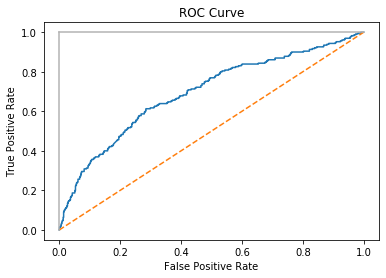

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score

y_score = model.predict_proba(test_x)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(test_y, y_score)
print('roc_auc_score = ', roc_auc_score(test_y, y_score))

plt.title('ROC Curve')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
#gammas = [0.1, 1, 10, 100]
# 0.1
# 1
# 10
# 100
for gamma in gammas:
   svc = svm.SVC(kernel="rbf", gamma=gamma).fit(train_x_rus, train_y_rus)
   predictions = model.predict(test_x) # problem?  
   report = classification_report(test_y, predictions, output_dict = True)
   ss = imblearn.metrics.sensitivity_specificity_support(test_y, predictions, average='macro')
  
   sensitivity.append(ss[0])
   specificity.append(ss[1])

   # F1 score: weighted average of the precision and recall
   f1_score_scores[0].append(report['0']['f1-score'])
   f1_score_scores[1].append(report['1']['f1-score'])

f1_score_scores_avg_0 = sum(f1_score_scores[0]) / 10
f1_score_scores_avg_1 = sum(f1_score_scores[1]) / 10
sensitivity_avg = sum(sensitivity) / 10
specificity_avg = sum(specificity) / 10

print("f1 score = ", (f1_score_scores_avg_0 + f1_score_scores_avg_1)/2)
print("sensitivity = ", sensitivity_avg)
print("specificity = ", specificity_avg)
print("train loss = ", model.score(train_x_rus, train_y_rus)) # look into how to decrease train loss
print("test loss = ", model.score(test_x, test_y))

from sklearn.metrics import hinge_loss
print("hinge loss = ", hinge_loss(test_y, predictions))

f1 score =  0.8857868273012395
sensitivity =  0.8915909460999838
specificity =  0.8915909460999838
train loss =  0.714622641509434
test loss =  0.810223642172524
hinge loss =  1.0428115015974442


In [0]:
from sklearn.metrics import hinge_loss
hinge_loss(test_y, predictions)

1.0012779552715656

In [0]:
print(len(x))
print(len(train_x_rus))
print(len(test_x))

print(len(y))
print(len(train_y_rus))
print(len(test_y))

print(x.shape)
print(train_x_rus.shape)
print(test_x.shape)

print(y.shape)
print(train_y_rus.shape)
print(test_y.shape)

print(predictions.shape)
print(model)

5215
1272
1565
5215
1272
1565
(5215, 6)
(1272, 6)
(1565, 6)
(5215,)
(1272,)
(1565,)
(1565,)
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [0]:
print(len(train_x_rus))
print(len(train_y_rus))

print(train_x_rus[:,1].shape)
print(train_y_rus.shape)

602
602
(602,)
(602,)


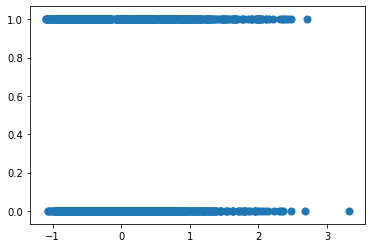

In [0]:
plt.scatter(train_x_rus[:,1], train_y_rus, s=50, cmap='seismic')
plt.show()

In [0]:
count_0 = 0
count_1 = 0
for x in bg.Sepsis.values:
  if int(x) == 1:
    count_1 += 1
  else:
    count_0 += 1

print(count_0)
print(count_1)

4476
739


 predict_proba: predicts the probabilities of various classes

## **Attempt to Plot Hyperplanes**

f1 score =  0.6072170372575358
sensitivity =  0.6047630679042503
specificity =  0.6047630679042503


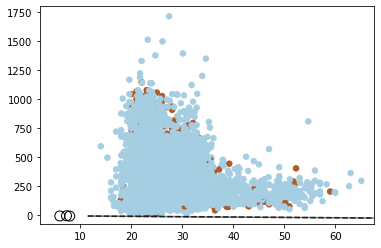

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

x = bg[['Hct', 'Platelet', 'WBC', 'Temp', 'RR', 'HR']].values
y = bg['Sepsis'].values

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=0)

#scaler = StandardScaler() 
#scaler = MinMaxScaler() 
#scaler = MaxAbsScaler() 
scaler = RobustScaler() 
#scaler = PowerTransformer() 
#scaler = QuantileTransformer() 

train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x) # change this to change test_x

n_minority = len(train_y[train_y == 1])
n_majority = int(n_minority * 1.5)
sampling_numbers = {0: n_majority, 1: n_minority}

rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=sampling_numbers)
train_x_rus, train_y_rus = rus.fit_resample(train_x, train_y)
train_y_rus = pd.Series(train_y_rus)

f1_score_scores = [[],[]]
sensitivity = []
specificity = []

model = svm.SVC(kernel="rbf", probability=True)

for i in range(0,10):
  model.fit(train_x_rus, train_y_rus)
  predictions = model.predict(test_x) # problem?  
  report = classification_report(test_y, predictions, output_dict = True)
  ss = imblearn.metrics.sensitivity_specificity_support(test_y, predictions, average='macro')
  
  sensitivity.append(ss[0])
  specificity.append(ss[1])

  # F1 score: weighted average of the precision and recall
  f1_score_scores[0].append(report['0']['f1-score'])
  f1_score_scores[1].append(report['1']['f1-score'])

f1_score_scores_avg_0 = sum(f1_score_scores[0]) / 10
f1_score_scores_avg_1 = sum(f1_score_scores[1]) / 10
sensitivity_avg = sum(sensitivity) / 10
specificity_avg = sum(specificity) / 10

print("f1 score = ", (f1_score_scores_avg_0 + f1_score_scores_avg_1)/2)
print("sensitivity = ", sensitivity_avg)
print("specificity = ", specificity_avg)



plt.scatter(x[:, 0], x[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

Automatically created module for IPython interactive environment


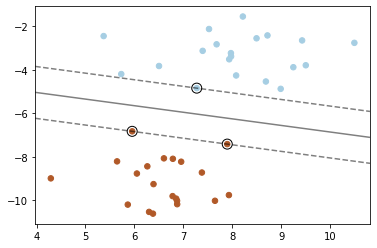

In [0]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs


# we create 40 separable points
X, y = make_blobs(n_samples=40, centers=2, random_state=6)

# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

# **SVC Parameters When Using RBF Kernel**

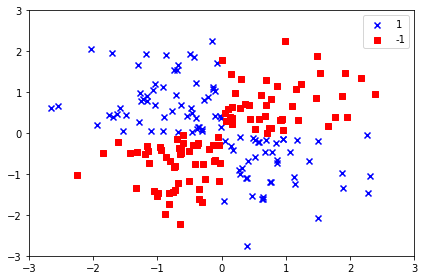

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


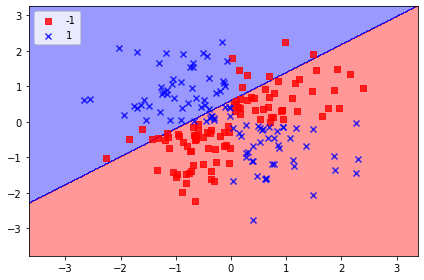

In [0]:
# DON'T RUN ------------------------------------------------------------------
# DON'T RUN
# DON'T RUN
# DON'T RUN

# https://chrisalbon.com/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/

# Import packages to visualize the classifer
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings

# Import packages to do the classifying
import numpy as np
from sklearn.svm import SVC

def versiontuple(v):
    return tuple(map(int, (v.split("."))))


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')


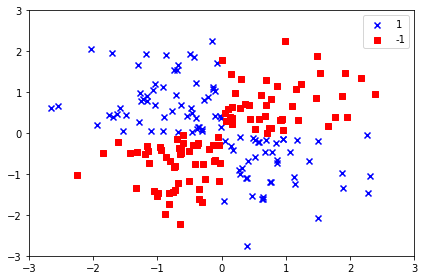

In [0]:
np.random.seed(0)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


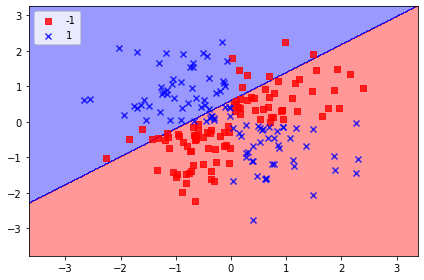

In [0]:
# Create a SVC classifier using a linear kernel
svm = SVC(kernel='linear', C=1, random_state=0)
# Train the classifier
svm.fit(X_xor, y_xor)

# Visualize the decision boundaries
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


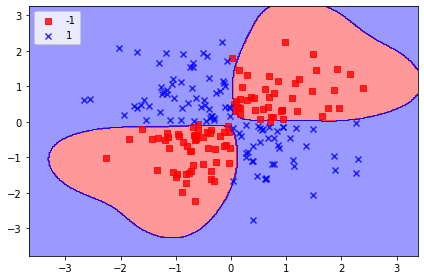

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


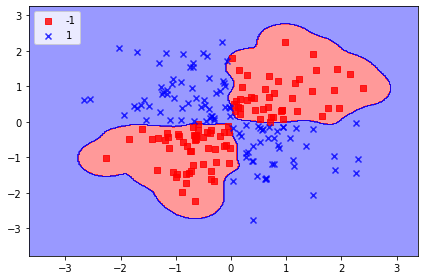

In [0]:
# Create a SVC classifier using an RBF kernel
svm = SVC(kernel='rbf', random_state=0, gamma=1, C=1)
# Train the classifier
svm.fit(X_xor, y_xor)

# Visualize the decision boundaries
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Create a SVC classifier using an RBF kernel
svm = SVC(kernel='rbf', random_state=0, gamma=10, C=1)
# Train the classifier
svm.fit(X_xor, y_xor)

# Visualize the decision boundaries
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [0]:
# Create a SVC classifier using an RBF kernel
svm = SVC(kernel='rbf', random_state=0, gamma=.01, C=1000)
# Train the classifier
svm.fit(X_xor, y_xor)

# Visualize the decision boundaries
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

NameError: ignored

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn import svm
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
import imblearn

# Import packages to visualize the classifer
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings

# Import packages to do the classifying
import numpy as np
from sklearn.svm import SVC

In [0]:
def versiontuple(v):
    return tuple(map(int, (v.split("."))))


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    # classifier = SVM
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

f1 score =  0.4863255041655805
sensitivity =  0.502263475004071
specificity =  0.502263475004071


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


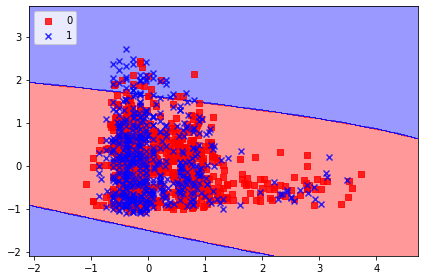

In [0]:
# x = bg[['Hct', 'Platelet', 'WBC', 'Temp', 'RR', 'HR']].values
x = bg[['Hct', 'Platelet']].values
y = bg['Sepsis'].values

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=0)

#scaler = StandardScaler() 
#scaler = MinMaxScaler() 
#scaler = MaxAbsScaler() 
scaler = RobustScaler() 
#scaler = PowerTransformer() 
#scaler = QuantileTransformer() 

train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x) # change this to change test_x

n_minority = len(train_y[train_y == 1])
n_majority = int(n_minority * 1.5)
sampling_numbers = {0: n_majority, 1: n_minority}

rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=sampling_numbers)
train_x_rus, train_y_rus = rus.fit_resample(train_x, train_y)
train_y_rus = pd.Series(train_y_rus)

f1_score_scores = [[],[]]
sensitivity = []
specificity = []

model = svm.SVC(kernel="rbf", random_state=0, gamma=.01, C=100, probability=True)

for i in range(0,10):
  model.fit(train_x_rus, train_y_rus)
  predictions = model.predict(test_x) # problem?  
  report = classification_report(test_y, predictions, output_dict = True)
  ss = imblearn.metrics.sensitivity_specificity_support(test_y, predictions, average='macro')
  
  sensitivity.append(ss[0])
  specificity.append(ss[1])

  # F1 score: weighted average of the precision and recall
  f1_score_scores[0].append(report['0']['f1-score'])
  f1_score_scores[1].append(report['1']['f1-score'])

f1_score_scores_avg_0 = sum(f1_score_scores[0]) / 10
f1_score_scores_avg_1 = sum(f1_score_scores[1]) / 10
sensitivity_avg = sum(sensitivity) / 10
specificity_avg = sum(specificity) / 10

print("f1 score = ", (f1_score_scores_avg_0 + f1_score_scores_avg_1)/2)
print("sensitivity = ", sensitivity_avg)
print("specificity = ", specificity_avg)

# Visualize the decision boundaries
plot_decision_regions(train_x_rus, train_y_rus, classifier=model)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# **Takeaway: cannot plot more than 2 features for hyperplanes**